# Deriver Distruction Classification CNN Model

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow.compat.v1 as tf

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


%matplotlib inline


tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()


## Setting Model Parameters

In [3]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 120 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 7500 # Validation data size

STEPS = 3000     # 5000 #20000   # Number of steps to run
BATCH = 100 # Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 32 # Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 1024 # Number of hidden neurons in the fully connected layer

LR = 0.001 # Learning rate
DROPOUT = 0.75
LOGS_DIR = 'log_events'

## Load data set

In [4]:
# Training images
with open("array/x_train", "rb") as f:
    x_train = np.array(pickle.load(f), dtype=np.float64)
with open("array/y_train", "rb") as f:
    y_train = np.array(pickle.load(f))

# Validation images
with open("array/x_valid", "rb") as f:
    x_valid = np.array(pickle.load(f), dtype=np.float64)
with open("array/y_valid", "rb") as f:
    y_valid = np.array(pickle.load(f))
    
# Test images
with open("array/x_test", "rb") as f:
    x_test = np.array(pickle.load(f), dtype=np.float64)
with open("array/y_test", "rb") as f:
    y_test = np.array(pickle.load(f))

# Training Classes
with open("array/x_train_cls", "rb") as f:
    x_train_cls = np.asarray(pickle.load(f))
    
# Test Classes    
with open("array/y_test_cls", "rb") as f:
    y_valid_cls = np.asarray(pickle.load(f))

In [5]:
# Training and Valid data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1] * x_valid.shape[2])

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [6]:
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

n_train

40000

In [7]:
print("Training shape: ", x_train.shape)
print("Training Label: ", y_train.shape)

print("------------------------------")
print("Valid shape: ", x_valid.shape)
print("Valide Label: ", y_valid.shape)

print("------------------------------")
print("Test shape: ", x_test.shape)
print("Test Label: ", y_test.shape)

print("------------------------------")
print("Training Images Classes: ", x_train_cls.shape)
print("Test Images Classes: ", y_valid_cls.shape)

Training shape:  (40000, 14400)
Training Label:  (40000, 10)
------------------------------
Valid shape:  (10000, 14400)
Valide Label:  (10000, 10)
------------------------------
Test shape:  (12500, 14400)
Test Label:  (12500, 10)
------------------------------
Training Images Classes:  (35000,)
Test Images Classes:  (15000,)


In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(WIDTH, WIDTH), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

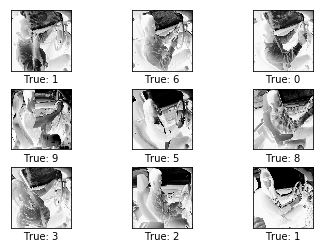

In [9]:
# Get the first images from the test-set.
images = x_valid[0:9]

# Get the true classes for those images.
cls_true = y_valid_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TF Graph Inputs

In [10]:
# Placeholder for training-set
x = tf.placeholder(tf.float32, shape=[None, WIDTH * WIDTH * CHANNELS], name='ph_x')
x_image = tf.reshape(x, [-1, WIDTH, WIDTH, CHANNELS])
y_true = tf.placeholder(tf.float32, shape=[None, LABELS], name='ph_y_true')

# Placeholder for dropout value
hold_prob = tf.placeholder(tf.float32, name='ph_hold_prob')

In [11]:
print(x.shape)

(?, 14400)


## Defining the Model Architecture

In [12]:
# Create some wrapper functions for simpliciy
def conv2d(x, W, b, strides=1):
    
    # Conv2D wrapper, with bias and relu-activation
    x = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)   
    
    return x




def maxpool2d(x, k=2):
    
    # MaxPool2D wrapper
    x = tf.nn.max_pool(x, [1, k, k, 1], [1, k, k, 1], padding='SAME')
    
    return x





# Create model
def conv_net(x, W, b, dropout):
        
    # Convolutional Layer 1
    conv1 = conv2d(x, W['wc1'], b['bc1'])
    conv1_pool1 = maxpool2d(conv1)
    print('Conv Layer 1: ', conv1_pool1.shape)
    
    # Convolutional Layer 2
    conv2 = conv2d(conv1_pool1, W['wc2'], b['bc2'])
    conv2_pool = maxpool2d(conv2)   
    print('Conv Layer 2: ', conv2_pool.shape)
    
    # Convolutional Layer 3
    conv3 = conv2d(conv2_pool, W['wc3'], b['bc3'])
    conv3_pool = maxpool2d(conv3)   
    print('Conv Layer 2: ', conv3_pool.shape)
    
    # Flatten Layer
    fl = tf.reshape(conv3_pool, (-1, W['wd1'].get_shape().as_list()[0]))
    print('Flatten Layer: ', fl.shape)   
    
    # Fully Connected Layer 
    fc = tf.nn.relu(tf.add(tf.matmul(fl, W['wd1']), b['bd1']))
    print('Fully Connected Layer: ', fc.shape)
    
    # Apply Dropout Layer
    fc = tf.nn.dropout(fc, rate= 1 - dropout)
    print('Dropout Layer: ', fc.shape)
    
    # Output , Class Prediction:
    y_pred = tf.add(tf.matmul(fc, W['out']), b['out']) 
    
    return y_pred, fc




# Store layers weights and biases
W = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1)),        
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2' : tf.Variable(tf.random_normal([PATCH, PATCH, DEPTH, 2 * DEPTH], stddev=0.1)),
    'wc3' : tf.Variable(tf.random_normal([PATCH, PATCH, 2 * DEPTH, 2 * DEPTH], stddev=0.1)),
    # 120 / (2x2)x2 = 120/8 = > 15 : two pooling layer applied on the input image of size 120x120
    # Fully connected layer : 15*15*64 inputs and 1024 outputs
    'wd1' : tf.Variable(tf.random_normal([15 * 15 * 2 * DEPTH, HIDDEN], stddev=0.1)),
    # 1024 inputs, 10 outputs (possible classes of prediction)
    'out' : tf.Variable(tf.random_normal([HIDDEN, LABELS], stddev=0.1))
}




b = {
    'bc1' : tf.Variable(tf.random_normal([DEPTH])), # [32]
    'bc2' : tf.Variable(tf.random_normal(shape=[2 * DEPTH])), # [64]
    'bc3' : tf.Variable(tf.random_normal(shape=[2 * DEPTH])), # [64]
    'bd1' : tf.Variable(tf.random_normal(shape=[HIDDEN])), # [1024]
    'out' : tf.Variable(tf.random_normal(shape=[LABELS])) # [10]
}


# Define Loss Function
## Define Optimizer
## Evaluate the Model

In [13]:

# Construct Model
# Logits (y_pred) are the unnormalized values produced in the last layer of the neural network.

y_pred, fc = conv_net(x_image, W, b, hold_prob)


# cross entropy loss, which often delivers better results in classification problems than the mean squared error
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))


# Finally, you will need to define an optimizer that takes in the loss and
# updates the weights of the neural network in the direction that minimizes the loss.
# Gradient Descent
optimizer = tf.train.AdamOptimizer(LR)

# Op to calculate every variable gradient
grads = tf.gradients(cost, tf.trainable_variables())
grads = list(zip(grads, tf.trainable_variables()))

# Op to update all variables according to their gradient
train =  optimizer.apply_gradients(grads)

# correct_pred: are the normalized version of the last neural network
correct_pred = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

W0502 19:08:10.046591 12796 deprecation.py:323] From <ipython-input-13-c2ed4c11ef6d>:9: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Conv Layer 1:  (?, 60, 60, 32)
Conv Layer 2:  (?, 30, 30, 64)
Conv Layer 2:  (?, 15, 15, 64)
Flatten Layer:  (?, 14400)
Fully Connected Layer:  (?, 1024)
Dropout Layer:  (?, 1024)


## Random Batch Generator

In [14]:
def random_batch(batch_size=32):
        
        # Create a random index into the training set
        indx = np.random.randint(low=0, high=len(x_train), size=batch_size)
        
        # Use the index to lookup random training data
        x_batch = x_train[indx]
        y_batch = y_train[indx]
        
        return x_batch, y_batch
    
    
    
def test_next_batch(batch_size=32):

    # Create a random index into the training set
    indx = np.random.randint(low=0, high=len(x_valid), size=batch_size)

    # Use the index to lookup random training data
    x_test_batch = x_valid[indx]
    y_test_batch = y_valid[indx]

    return x_test_batch, y_test_batch




def valid_next_batch(batch_size=32):

        # Create a random index into the training set
        indx = np.random.randint(low=0, high=len(x_valid), size=batch_size)

        # Use the index to lookup random training data
        x_valid_batch = x_valid[indx]
        y_valid_batch = y_valid[indx]

        return x_valid_batch, y_valid_batch

# Save the Model

In [15]:
saver = tf.train.Saver()

## Lounch Teh Graph Session

In [16]:
# STEPS = 3000

train_acc = []
train_loss = []
test_acc = []
test_loss = []
val_acc = []
val_loss = []

with tf.Session(config=config) as sess:
    
    # Run variable initializer
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(STEPS):
                
        train_batch = random_batch(BATCH)
        val_batch = valid_next_batch(BATCH)
        test_batch = test_next_batch(BATCH)
        
        sess.run(train, feed_dict={x: train_batch[0], y_true: train_batch[1], hold_prob: DROPOUT})
          
        if epoch % 100 == 0:
       
            c , acc = sess.run([cost, accuracy], feed_dict={x: train_batch[0], y_true: train_batch[1], hold_prob: DROPOUT})
            
            val_los, val_ac = sess.run([cost, accuracy], feed_dict={x: val_batch[0], y_true: val_batch[1], hold_prob:1.0})
            
            test_los, test_ac = sess.run([cost, accuracy], feed_dict={x: test_batch[0], y_true: test_batch[1], hold_prob:1.0})
            
            train_loss.append(c)
            train_acc.append(acc)
            
            val_acc.append(val_ac)
            val_loss.append(val_los)
            
            test_acc.append(test_ac)
            test_loss.append(test_los)
            
            msg = "Epoch {}. Acc: {:.3f}. Loss: {:.3f}. Test Acc: {:.3f}. Test Loss {:.3f}. Valid Acc: {:.3f}. Val Loss: {:.3f}"
            print(msg.format(epoch, acc, c, test_ac, test_los,  val_ac, val_los))
            
    # Once we are done the training, save the model
    saver.save(sess, 'model_weight/lee_model.chpt')
            
        

Epoch 0. Acc: 0.170. Loss: 389.041. Test Acc: 0.110. Test Loss 491.076. Valid Acc: 0.100. Val Loss: 348.130
Epoch 100. Acc: 0.140. Loss: 2.787. Test Acc: 0.120. Test Loss 2.301. Valid Acc: 0.090. Val Loss: 2.300
Epoch 200. Acc: 0.110. Loss: 2.642. Test Acc: 0.170. Test Loss 2.275. Valid Acc: 0.120. Val Loss: 2.320
Epoch 300. Acc: 0.160. Loss: 2.403. Test Acc: 0.250. Test Loss 2.173. Valid Acc: 0.290. Val Loss: 2.152
Epoch 400. Acc: 0.250. Loss: 2.104. Test Acc: 0.250. Test Loss 2.042. Valid Acc: 0.310. Val Loss: 2.068
Epoch 500. Acc: 0.260. Loss: 1.993. Test Acc: 0.330. Test Loss 1.861. Valid Acc: 0.340. Val Loss: 1.874
Epoch 600. Acc: 0.400. Loss: 1.657. Test Acc: 0.440. Test Loss 1.704. Valid Acc: 0.410. Val Loss: 1.729
Epoch 700. Acc: 0.470. Loss: 1.498. Test Acc: 0.460. Test Loss 1.614. Valid Acc: 0.470. Val Loss: 1.597
Epoch 800. Acc: 0.450. Loss: 1.609. Test Acc: 0.610. Test Loss 1.309. Valid Acc: 0.570. Val Loss: 1.365
Epoch 900. Acc: 0.520. Loss: 1.243. Test Acc: 0.550. Test Lo

# Plot the Loss and Accuracies

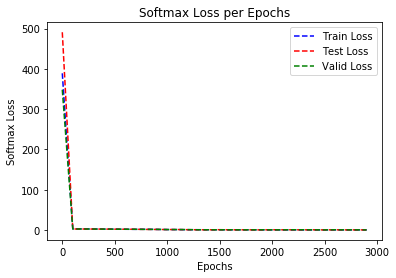

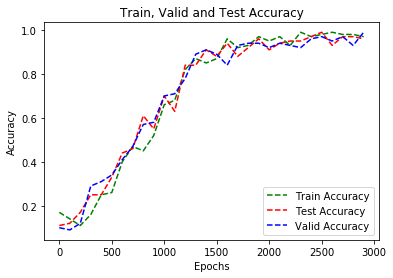

In [17]:
eval_indices = range(0, STEPS, 100)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'b--', label='Train Loss')
plt.plot(eval_indices, test_loss, 'r--', label='Test Loss')
plt.plot(eval_indices, val_loss, 'g--', label='Valid Loss')
plt.title('Softmax Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper right')
plt.show()
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'g--', label='Train Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Accuracy')
plt.plot(eval_indices, val_acc, 'b--', label='Valid Accuracy')
plt.title('Train, Valid and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()